## C02.02.F4.02. Train Model. Smoothed dataset.  Feature Selection

# Script for training the sellout extrapolation algorithm.

The training dataset is divided in two to have a new training dataset and the 
validation dataset. On the new training dataset the gridsearch is adjusted to 
obtain the best parameters that reduce the error when checking the results on 
the validation dataset. The cross validation error is also checked for the 
new training dataset.

In [1]:
# Import libraries 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, cross_val_score
import lightgbm as ltb
import matplotlib.pyplot as plt 
import joblib
import time 
import warnings
warnings.filterwarnings("ignore")
import sys
t1 = time.time()

    From an fitted model makes a prediction and returns the results.
    
    Parameters:
        model: Model object fitted.
        X: Data with the independent variables to predict
        y: Data with the dependient variable to compare with the prediction
        thresholds: List of thresholds where to check for each of them, the 
        number of records of X below them.
        verbose: Defines whether or not the output is displayed.
    
    Returns:
        results: Pandas Dataframe with the results of the predictions:
            - REAL: Real value of dependent variable.
            - PRED: Prediction value of dependent variable.
            - PERCENTAGE_ERROR:  Percentage deviation mean error by row from REAL and PRED.
            - ABSOLUTE_ERROR: Absolute mean error by row from REAL and PRED.
            - R2_SCORE: R square score from REAL and PRED.

In [2]:
def eval_model(model, X, y, thresholds=[5], verbose=1):
    y_pred = model.predict(X)
    y = np.power(y,3)
    y_pred = np.power(y_pred,3)
    porc_error = abs(y_pred - y)*100/y
    absolute_mean_error = mean_absolute_error(y, y_pred)
    porcentual_mean_error = np.mean(porc_error[porc_error != np.inf])
    if verbose:
        print("\nTEST: Absolute Error:", absolute_mean_error)
        print("Porcentual Error:", porcentual_mean_error)
        print("STD Error:", np.std(abs(y - y_pred)))
        print("R2 Score:", r2_score(y, y_pred)) #Coef determ
    results = pd.DataFrame(np.array(y), columns = ['REAL'])
    results['PRED'] = y_pred
    results['PERCENTAGE_ERROR'] = np.abs(results['PRED'] - results['REAL'])*100/results['REAL'] 
    results['ABSOLUTE_ERROR'] = np.abs(results['PRED'] - results['REAL'])*100
    results['R2_SCORE'] = r2_score(results['REAL'], results['PRED'])
    
    for threshold in thresholds:
        hits = 0
        for element in results['ABSOLUTE_ERROR']:
            if element <= threshold:
                hits+=1
        
        porcentual_hits = hits*100/len(results)
        if verbose:
            print(str(porcentual_hits)+str("% registers are with less than"), str(threshold)+str("% of absolute error."))
            results['% REG ERROR < '+str(threshold)] = porcentual_hits
        
    return results

In [3]:
# Define INPUT and OUTPUT files
INPUT = '../02_Data/prepared_train.csv'
INPUT_FEATS = '../02_Data/features.npy'
OUTPUT_MODEL = '../02_Data/model.pkl'
OUTPUT_SC = '../02_Data/sc_X.bin'
OUTPUT_TRAIN_RES = '../02_Data/train_results.csv'
OUTPUT_VAL_RES = '../02_Data/val_results.csv'

In [4]:
# Read best features from feature selection
features = np.load(INPUT_FEATS).tolist()

In [5]:
# Read data resetting the indexes
data = pd.read_csv(INPUT, sep='|').reset_index(drop=True)

In [6]:
# Indexing the independent and dependent variables in X and y respectively
X = data[features + ['CUSTOMER_ID','BRANDFAMILY_ID']]
y = data['QUOTA_SELLOUT']

#### Given goal is to predict sales of customers for whom we have no Target data, the selection of train and test is done by choosing random customers, instead of random transactions.

In [7]:
# Getting unique customers and shuffle them
customers = X['CUSTOMER_ID'].drop_duplicates().reset_index(drop=True)
index = np.random.permutation(len(customers))
customers = customers.loc[index].reset_index(drop=True)

In [8]:
# Separate train and val customers by ratio
ratio = 0.9
train = customers[:int(np.round(len(customers)*ratio))]
val = customers[int(np.round(len(customers)*ratio)):]

In [9]:
val

4925    39000609
4926     4020400
4927    28010106
4928     6000319
4929    28950491
          ...   
5467     4030490
5468     8950800
5469    30080089
5470     6120687
5471    47000237
Name: CUSTOMER_ID, Length: 547, dtype: int64

In [10]:
train

0       28071330
1        7000243
2       45070133
3       29050077
4        7004823
          ...   
4920    32020018
4921    20020277
4922     2000065
4923    23000821
4924    13050117
Name: CUSTOMER_ID, Length: 4925, dtype: int64

In [11]:
# Obtain the indexes of the dataset where the customers are located
index_train = X['CUSTOMER_ID'].isin(train)
index_val = X['CUSTOMER_ID'].isin(val)

X_train = X[index_train].reset_index(drop=True)
X_val = X[index_val].reset_index(drop=True)

y_train = y[index_train].reset_index(drop=True)
y_val = y[index_val].reset_index(drop=True)

In [12]:
# Create peer groups of customers for cross-validation
groups = X_train.CUSTOMER_ID
group_KFold = GroupKFold(n_splits=5)

In [13]:
# Remove CUSTOMER_ID from data
X_train = X_train.drop(['CUSTOMER_ID','BRANDFAMILY_ID'], axis=1)
X_val = X_val.drop(['CUSTOMER_ID','BRANDFAMILY_ID'], axis=1)
X = X.drop(['CUSTOMER_ID','BRANDFAMILY_ID'], axis=1)

In [14]:
# Apply a data scaling with StandardScaler on X_train and transform on X_val
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.transform(X_val)

In [15]:
# Save StandardScaler configuration to file for future use
joblib.dump(sc_X, OUTPUT_SC, compress=True)

['../02_Data/sc_X.bin']

In [16]:
# Transform train and val dependent variable to a gaussian distribution
y_train = y_train**(float(1)/3)
y_val = y_val**(float(1)/3)

In [17]:
# Boolean to choose the use of gridsearch
grid_search = False
if grid_search:
    # Define parameters for the gridsearch
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100, 200],
        'num_leaves': [12, 16, 31],
        'random_state' : [501],
        'colsample_bytree' : [0.65, 0.66, 1.0],
        'subsample' : [0.75, 1.0],
        'reg_alpha' : [0.0, 1.0, 1.2],
        'reg_lambda' : [0.0, 1.0, 1.2],
    }
    # Define the estimator base model
    estimator = ltb.LGBMRegressor()
    
    # Define de type of gridsearch (RandomizedSearchCV) and fit for get the best parameters
    model = RandomizedSearchCV(estimator = estimator, param_distributions = param_grid, n_iter = 50, cv = group_KFold.split(X_train, y_train, groups), verbose=1, random_state=27, n_jobs = -1)
    model.fit(X_train, y_train)
    
    # Get the best estimator into model
    model = model.best_estimator_
    
    # Check the scores of the model with cross validation and R squared metric on train data
    scores = cross_val_score(model, X_train, y_train, cv=group_KFold.split(X_train, y_train, groups), scoring='r2')    
    

else:
    # Define predefined model
    model = ltb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    
    # Check the scores of the model with cross validation and R squared metric on train data
    scores = cross_val_score(model, X_train, y_train, cv=group_KFold.split(X_train, y_train, groups), scoring='r2')     
       
    # Fit the model with train data
    model.fit(X_train, y_train)

In [18]:
# Save model configuration to file for future use
joblib.dump(model, OUTPUT_MODEL)

['../02_Data/model.pkl']

In [19]:
# Get results from evaluate the model with train and val data
res_train = eval_model(model, X_train, y_train, [1, 2, 5, 10], verbose=1)
res_val = eval_model(model, X_val, y_val, [1, 2, 5, 10], verbose=1)


TEST: Absolute Error: 0.015066693675346143
Porcentual Error: 45.517671995772105
STD Error: 0.023796394391613997
R2 Score: 0.8995185824043825
59.71175573498182% registers are with less than 1% of absolute error.
78.01564794836877% registers are with less than 2% of absolute error.
93.68810696651443% registers are with less than 5% of absolute error.
98.71575371582902% registers are with less than 10% of absolute error.

TEST: Absolute Error: 0.014914166558222737
Porcentual Error: 44.93553286909487
STD Error: 0.023181595331399806
R2 Score: 0.9058009380268809
60.01241459539705% registers are with less than 1% of absolute error.
78.1249186106071% registers are with less than 2% of absolute error.
93.7269396720116% registers are with less than 5% of absolute error.
98.78632137307162% registers are with less than 10% of absolute error.


##### Good result with an R2 of 90%.

In [20]:
# Format results dataframes for write to file
res_train = data[index_train][['CUSTOMER_ID','BRANDFAMILY_ID','CAL_DATE','CAL_DATE_end']].reset_index(drop=True).merge(res_train, left_index=True, right_index=True)
res_val = data[index_val][['CUSTOMER_ID','BRANDFAMILY_ID','CAL_DATE','CAL_DATE_end']].reset_index(drop=True).merge(res_val, left_index=True, right_index=True)

res_train['CV_R2_SCORE'] = scores.mean()

In [21]:
# The data is written to a file
res_train.to_csv(OUTPUT_TRAIN_RES, sep='|', index=False)
res_val.to_csv(OUTPUT_VAL_RES, sep='|', index=False)

##  Features Impact on Prediction 

In [23]:
##  Features Impact on Prediction import seaborn as sns
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()   
    plt.show()

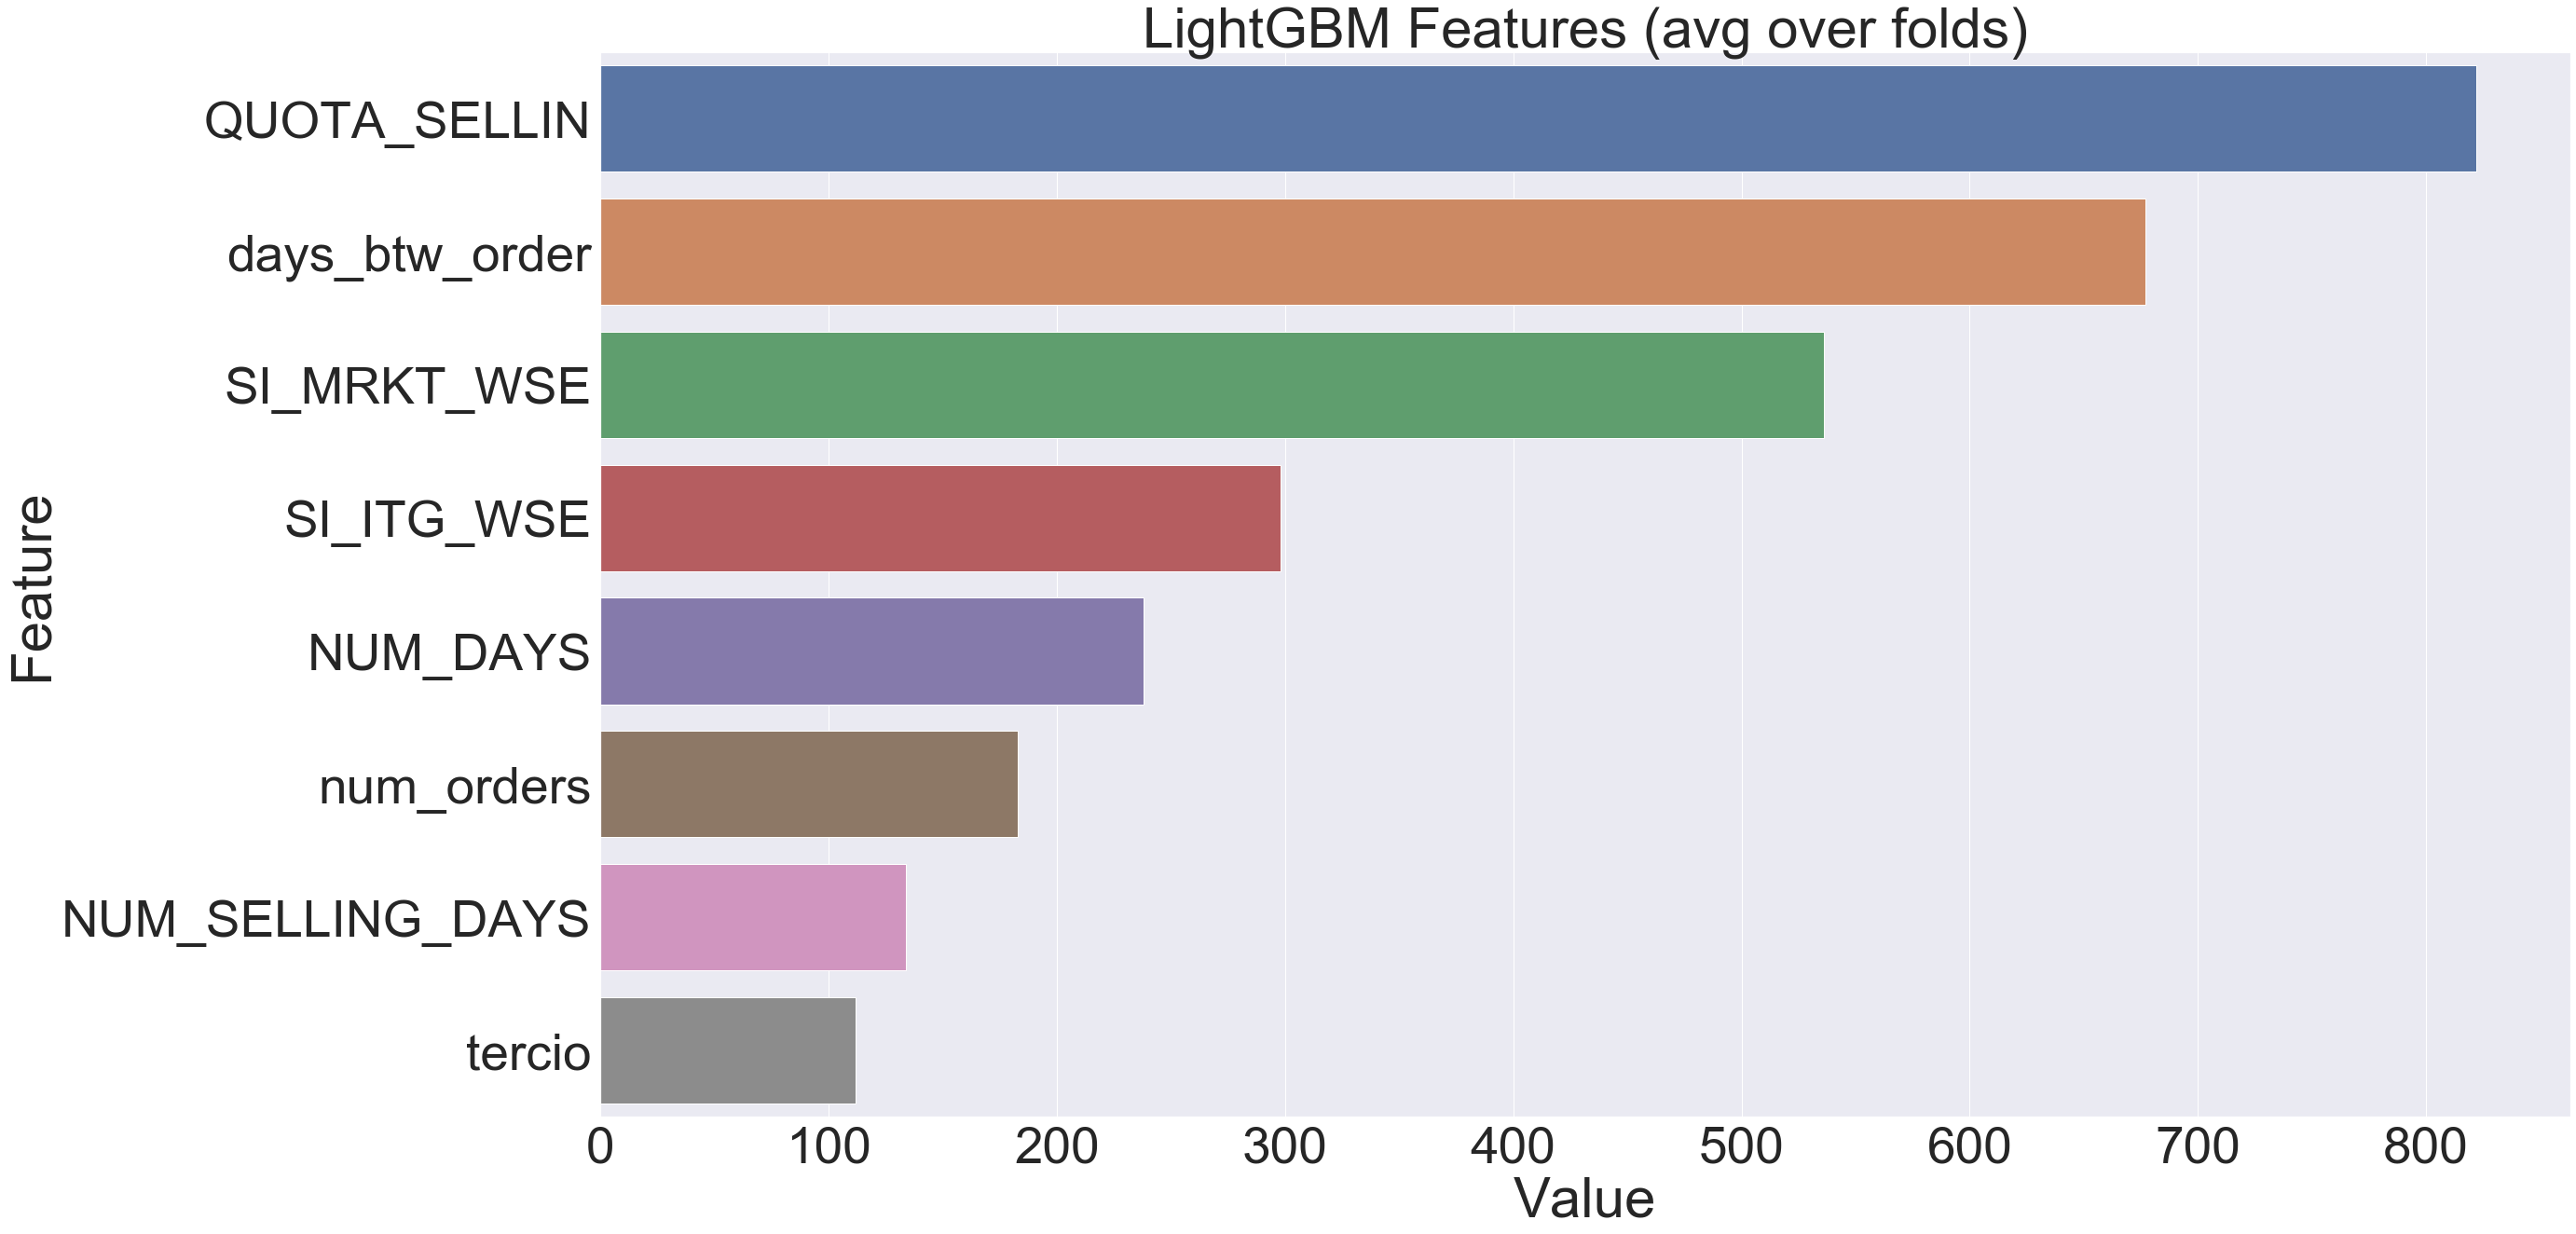

In [25]:
plotImp(model, features , num = 20, fig_size = (40, 20))

#### Impact focus on DAYS and SELL  Features

In [22]:
t2 = time.time()
print ("Time to execute script:",str(round((t2-t1)/3600,2)), "h")

Time to execute script: 0.18 h
